In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
import time

In [2]:
T = np.inf

model = tf.keras.models.load_model('hybrid_map_no_dephasing')

In [3]:
class Hybrid:
    
    def __init__(self, T_):
        
        self.mu = 0
        self.sig = 0.5
        self.T = T_
        self.tau = None
        
    def experiment(self):
        
        if self.mu < 6*self.sig:
            
            nn_map = model(np.array([[self.mu, self.sig]])).numpy()[0]
            
            self.tau = 2*nn_map[0]/self.sig

        
        else:
            
            k = np.floor(self.mu/(np.pi*np.sqrt(self.sig**2+2/T**2))+0.5)
            self.tau = (k-0.5)*np.pi/self.mu
            
        return self.tau
        
        
    def update(self, d):
        
        if self.mu < 6*self.sig:
            
            nn_map = model(np.array([[self.mu, self.sig]])).numpy()[0]
            
            if d == 0:
                
                self.mu = abs(nn_map[1]*self.sig+self.mu)
                self.sig = abs(nn_map[2]*self.sig)
            
            if d == 1:
                
                self.mu = abs(nn_map[3]*self.sig+self.mu)
                self.sig = abs(nn_map[4]*self.sig)
        
        else:
            
            k = np.floor(self.mu/(np.pi*np.sqrt(self.sig**2+2/T**2))+0.5)
            
            ex_ = self.mu \
            -np.pi*(2*d-1)*(-1)**k*(2*k-1)*self.sig**2*np.exp(-np.pi**2*(self.sig**2+2/T**2)*(1-2*k)**2/(8*self.mu**2))/(2*self.mu)
            
            var_ = self.sig**2 \
            -(np.pi*(2*d-1)*(2*k-1)*self.sig**2)**2*np.exp(-np.pi**2*(self.sig**2+2/T**2)*(1-2*k)**2/(4*self.mu**2))/(2*self.mu)**2
            
            self.mu = ex_
            self.sig = np.sqrt(var_)
        
    def reset(self):
        self.mu = 0
        self.sig = 0.5
        self.tau = None
        
def FID(true_w, t, T2):

    # Simulate measurement
    p0 = (1 + np.exp(-(t/T2)**2)*np.cos(true_w*t))/2
    draw = np.random.uniform(0,1)
    d = int(draw > p0)
    
    return d


In [4]:
n_loops = 50
n_reps = 10000

data = np.zeros((3, n_reps, n_loops))

ex = Hybrid(T)


def loop(ex, n_loops, n_reps, data):
    
    i = 0
    while i < n_reps:
        
        # Draw a true value to be estimated from a Gaussian distribution
        true_w = abs(np.random.normal(loc=0, scale=0.5))
        
        # Add a progress tracker since the program takes a little while
        if i in [n_reps//10*k for k in range(1, 10)]:
            print(round(100*i/n_reps), "% completed")
            
        ex.reset()
        
        # Perform estimation with n_loops number of measurements
        for j in range(1,n_loops+1):
            
            time = ex.experiment()
            
            meas = FID(true_w, time, T)
            
            ex.update(meas)

            # Save posterior stdev, estimation error and experiment time
            data[0,i,j-1] = ex.sig
            data[1,i,j-1] = abs(ex.mu-true_w)
            data[2,i,j-1] = ex.tau
            
        i += 1
    
    return data

start = time.time()

data = loop(ex, n_loops, n_reps, data)

end = time.time()

print()
print('Time elapsed:', end-start, 'seconds')

10 % completed
20 % completed
30 % completed
40 % completed
50 % completed
60 % completed
70 % completed
80 % completed
90 % completed

Time elapsed: 231.9208676815033 seconds


/tmp/ipykernel_1149558/1656362380.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


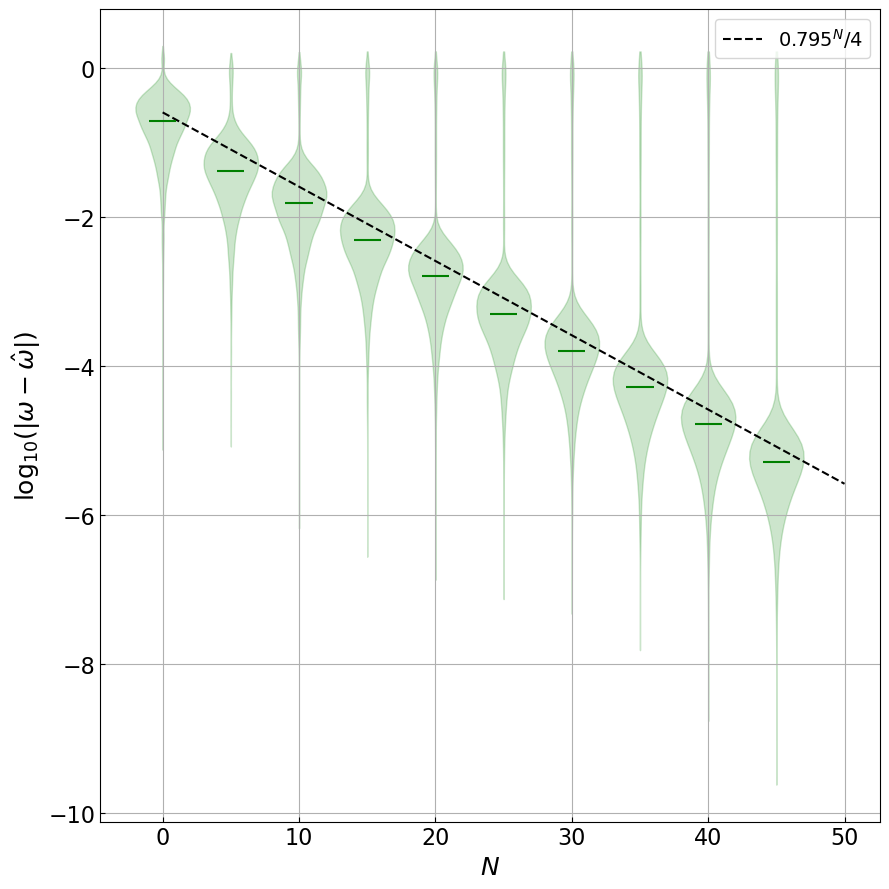

In [5]:
fig, ax1 = plt.subplots(1,1,figsize=(9,9))

# "Linear" guide to the eye (log of an exponential function)
plt.plot(np.arange(51), np.log10(0.25*0.632**(np.arange(51)/2)), ls='--', color='k', label=r'$0.795^{N}/4$')

violin_parts = ax1.violinplot(np.log10(data[1,:,0::5]), 
                              positions=np.arange(50)[0::5], widths=4, showmedians=True, 
                              showextrema=False, showmeans=False, points=100)
for vp in violin_parts['bodies']:
    vp.set_color('green')
    vp.set_alpha(0.2)
violin_parts['cmedians'].set_color('green')


ax1.tick_params(labelsize=16, direction='in')
ax1.set_xlabel(r'$N$', fontsize=18)
ax1.set_ylabel(r'$\log_{10}(|\omega-\hat{\omega}|)$', fontsize=18)
ax1.grid()
ax1.legend(fontsize=14)
fig.tight_layout()
fig.show()